# Latest dataset exploration - n=133
This notebook focuses on the implementation of the Cob class, which encompasses the analysis developed as part of the initial exploration of 15min sampled data as the output of Isabella Dagen's insulin-need project preprocessing. It uses the Cob class from cob_analysis.py to analyse the data and create peak features to investigate the existence of diurnal patterns in the data.

In [33]:
%load_ext autoreload
%autoreload 2
from src.config import INTERIM_DATA_DIR

import pandas as pd
from src.cob_analysis import Cob, hierarchical_clustering, plot_cob_by_hour, plot_by_hour_individuals

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Previous preprocessing - 15 min sampled data based on earlier limited dataset
cob_old = Cob()
cob_old.read_interim_data(file_name='15min_iob_cob_bg_old_sample',
                      file_type='csv',
                      sampling_rate=15)

Number of records: 599360
Number of people: 116
Systems used: 	['OpenAPS']
Categories (1, object): ['OpenAPS']


In [4]:
# Compare briefly against the new dataset
cob_new = Cob()
cob_new.read_interim_data(file_name='15min_iob_cob_bg',
                      file_type='csv',
                      sampling_rate=15)

Number of records: 786757
Number of people: 133
Systems used: 	['OpenAPS']
Categories (1, object): ['OpenAPS']


In [5]:
# And compare to make sure missing values etc are the same
pid = 221634
cob_old.get_person_data(pid)
cob_new.get_person_data(pid)
cob_old.summarise_missing_for_individual()
cob_new.summarise_missing_for_individual()

MISSING DATA SUMMARY FOR 221634
Start of time series: 2018-03-16 20:30:00+00:00
End of time series: 2018-07-18 21:30:00+00:00
Samples: 2918
NaN values: 0
15-minute intervals in range: 11909
Missing samples: 8991
Total missing (NaNs and missing): 8991
Days in range: 124.05
Total % missing: 75.50
Days with COB data: 107
Days with missing data: 17.05
Number of gaps: 0
Mean length of gaps (in days): nan

MISSING DATA SUMMARY FOR 221634
Start of time series: 2018-03-16 20:30:00+00:00
End of time series: 2018-07-18 21:30:00+00:00
Samples: 2918
NaN values: 0
15-minute intervals in range: 11909
Missing samples: 8991
Total missing (NaNs and missing): 8991
Days in range: 124.05
Total % missing: 75.50
Days with COB data: 107
Days with missing data: 17.05
Number of gaps: 0
Mean length of gaps (in days): nan



{'n': 2918,
 'nans': np.int64(0),
 'min_date': Timestamp('2018-03-16 20:30:00+0000', tz='UTC'),
 'max_date': Timestamp('2018-07-18 21:30:00+0000', tz='UTC'),
 'num_intervals': 11909,
 'missing_samples': 8991,
 'total_missing': np.int64(8991),
 'days_in_range': 124.05208333333333,
 'missing_percent': np.float64(75.49752288185407),
 'days_with_data': 107,
 'days_with_missing_data': 17.05208333333333,
 'num_gaps': 0,
 'mean_gap_length_days': nan}

In [6]:
# Now lets look at processing the dataset to find the peaks, which will interpolate (to avoid increasing the number of peaks artificially) and same the processed data as a parquet file
cob_new_df = cob_new.pre_process_batch(height=15, distance=5, suppress=True)

No IDs provided. Processing all 133 records.


No IDs provided. Processing all 116 records.


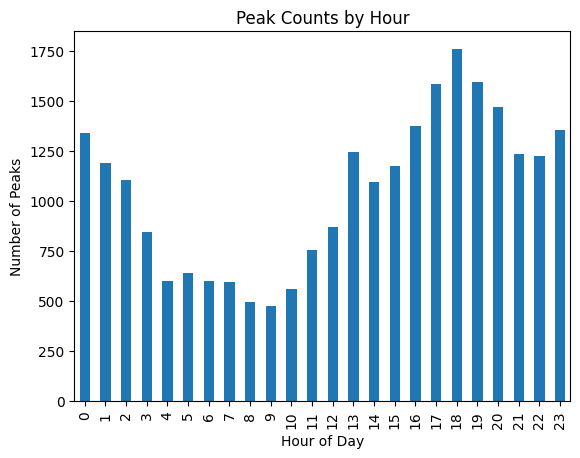

In [7]:
cob_old_df = cob_old.pre_process_batch(height=15, distance=5, suppress=True)
plot_cob_by_hour(cob_old_df)

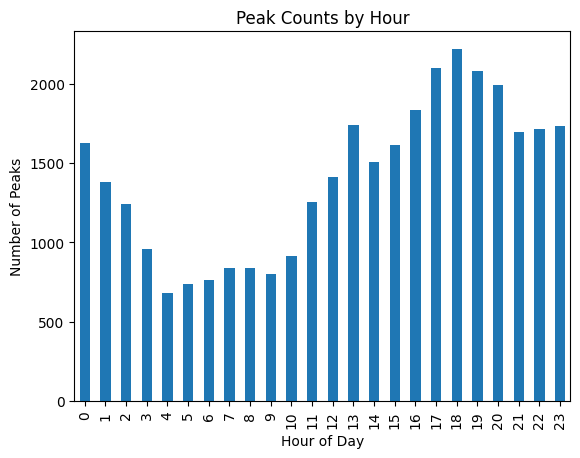

In [8]:
plot_cob_by_hour(cob_new_df)

This has now shown that despite the changes to localisation of datetime in the dataset, the peaks are still similar. We will focus on finding a set of well-behaved samples with rich COB data, and might help determine how far they are from the population profile.

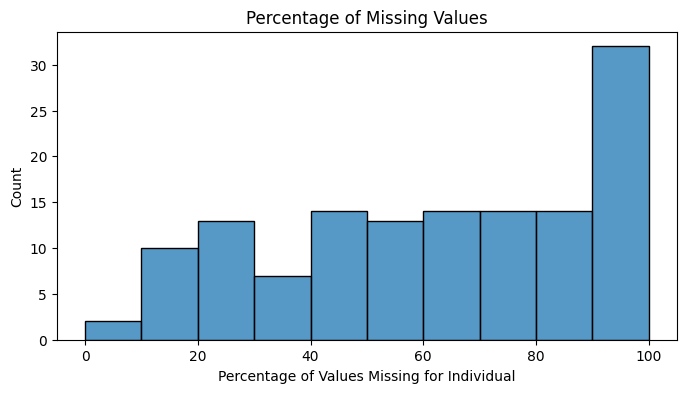

In [9]:
df_stats = cob_new.summarise_missing_for_dataset()

Now we've built a dataframe of variables we may use, we can start to see if there are clusters of people that meet the traits that we need in order to see if they have better-behaved data. One method we can use is hierarchical clustering, which will allow us to build a dendrogram to see if there are clusters of people that are similar data attributes, which favour a better behaved distribution of daily COB peaks.

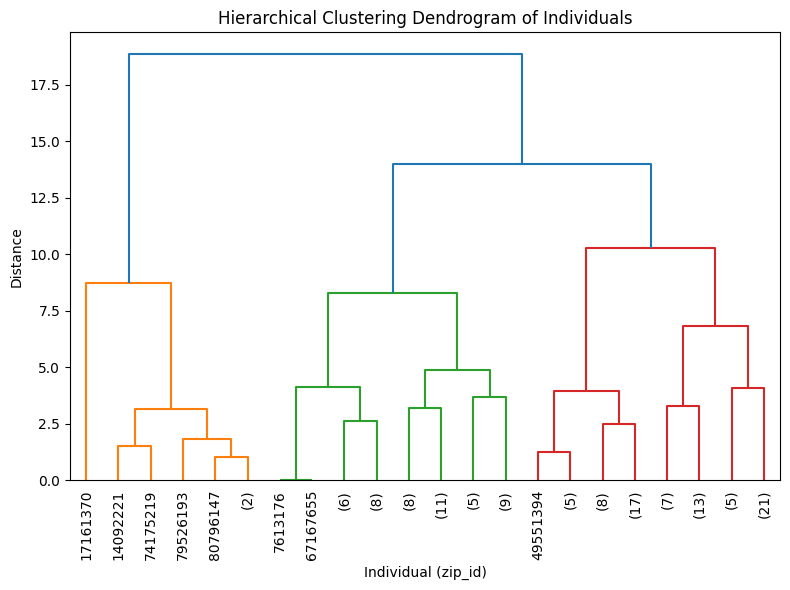


Cluster Sizes:
Cluster 2: 1 individuals
Cluster 1: 6 individuals
Cluster 3: 16 individuals
Cluster 6: 20 individuals
Cluster 7: 26 individuals
Cluster 5: 31 individuals
Cluster 4: 33 individuals


<Figure size 1000x800 with 0 Axes>

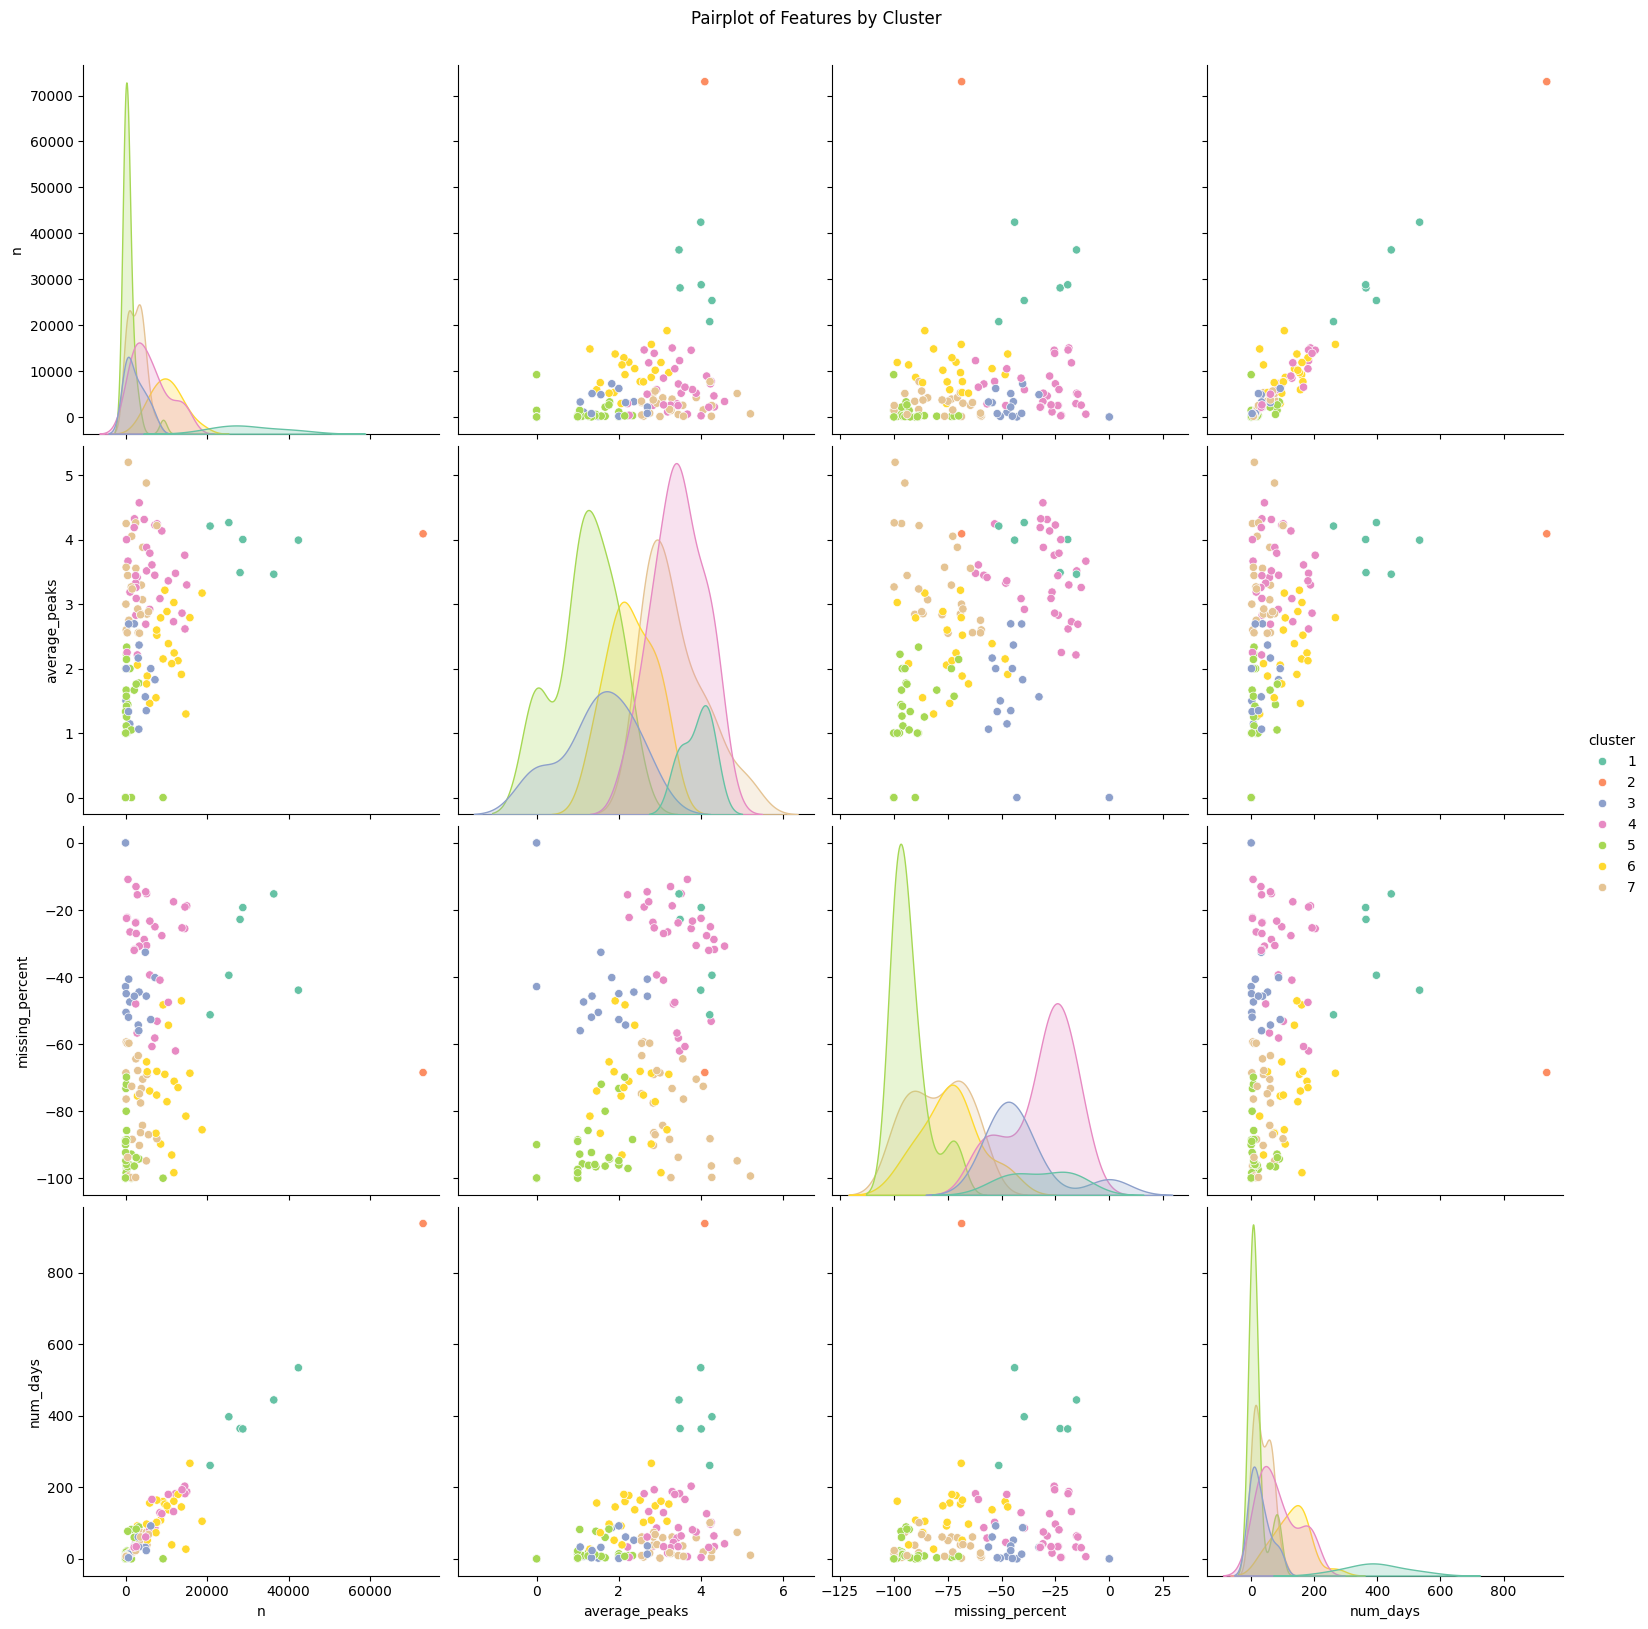

In [10]:
feature_cols = ['n','average_peaks','missing_percent','num_days']
df_summary = hierarchical_clustering(df_stats, feature_cols=feature_cols)

There is an outlier in the data that has a very high number of peaks and days with data. We'll remove this so we can get a better view of the data.


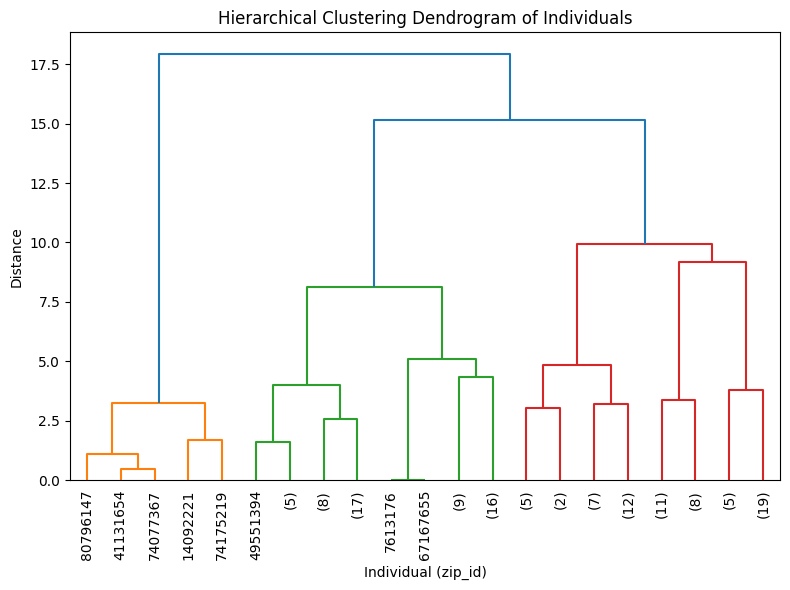


Cluster Sizes:
Cluster 3: 2 individuals
Cluster 1: 5 individuals
Cluster 6: 19 individuals
Cluster 7: 24 individuals
Cluster 4: 25 individuals
Cluster 5: 26 individuals
Cluster 2: 31 individuals


<Figure size 1000x800 with 0 Axes>

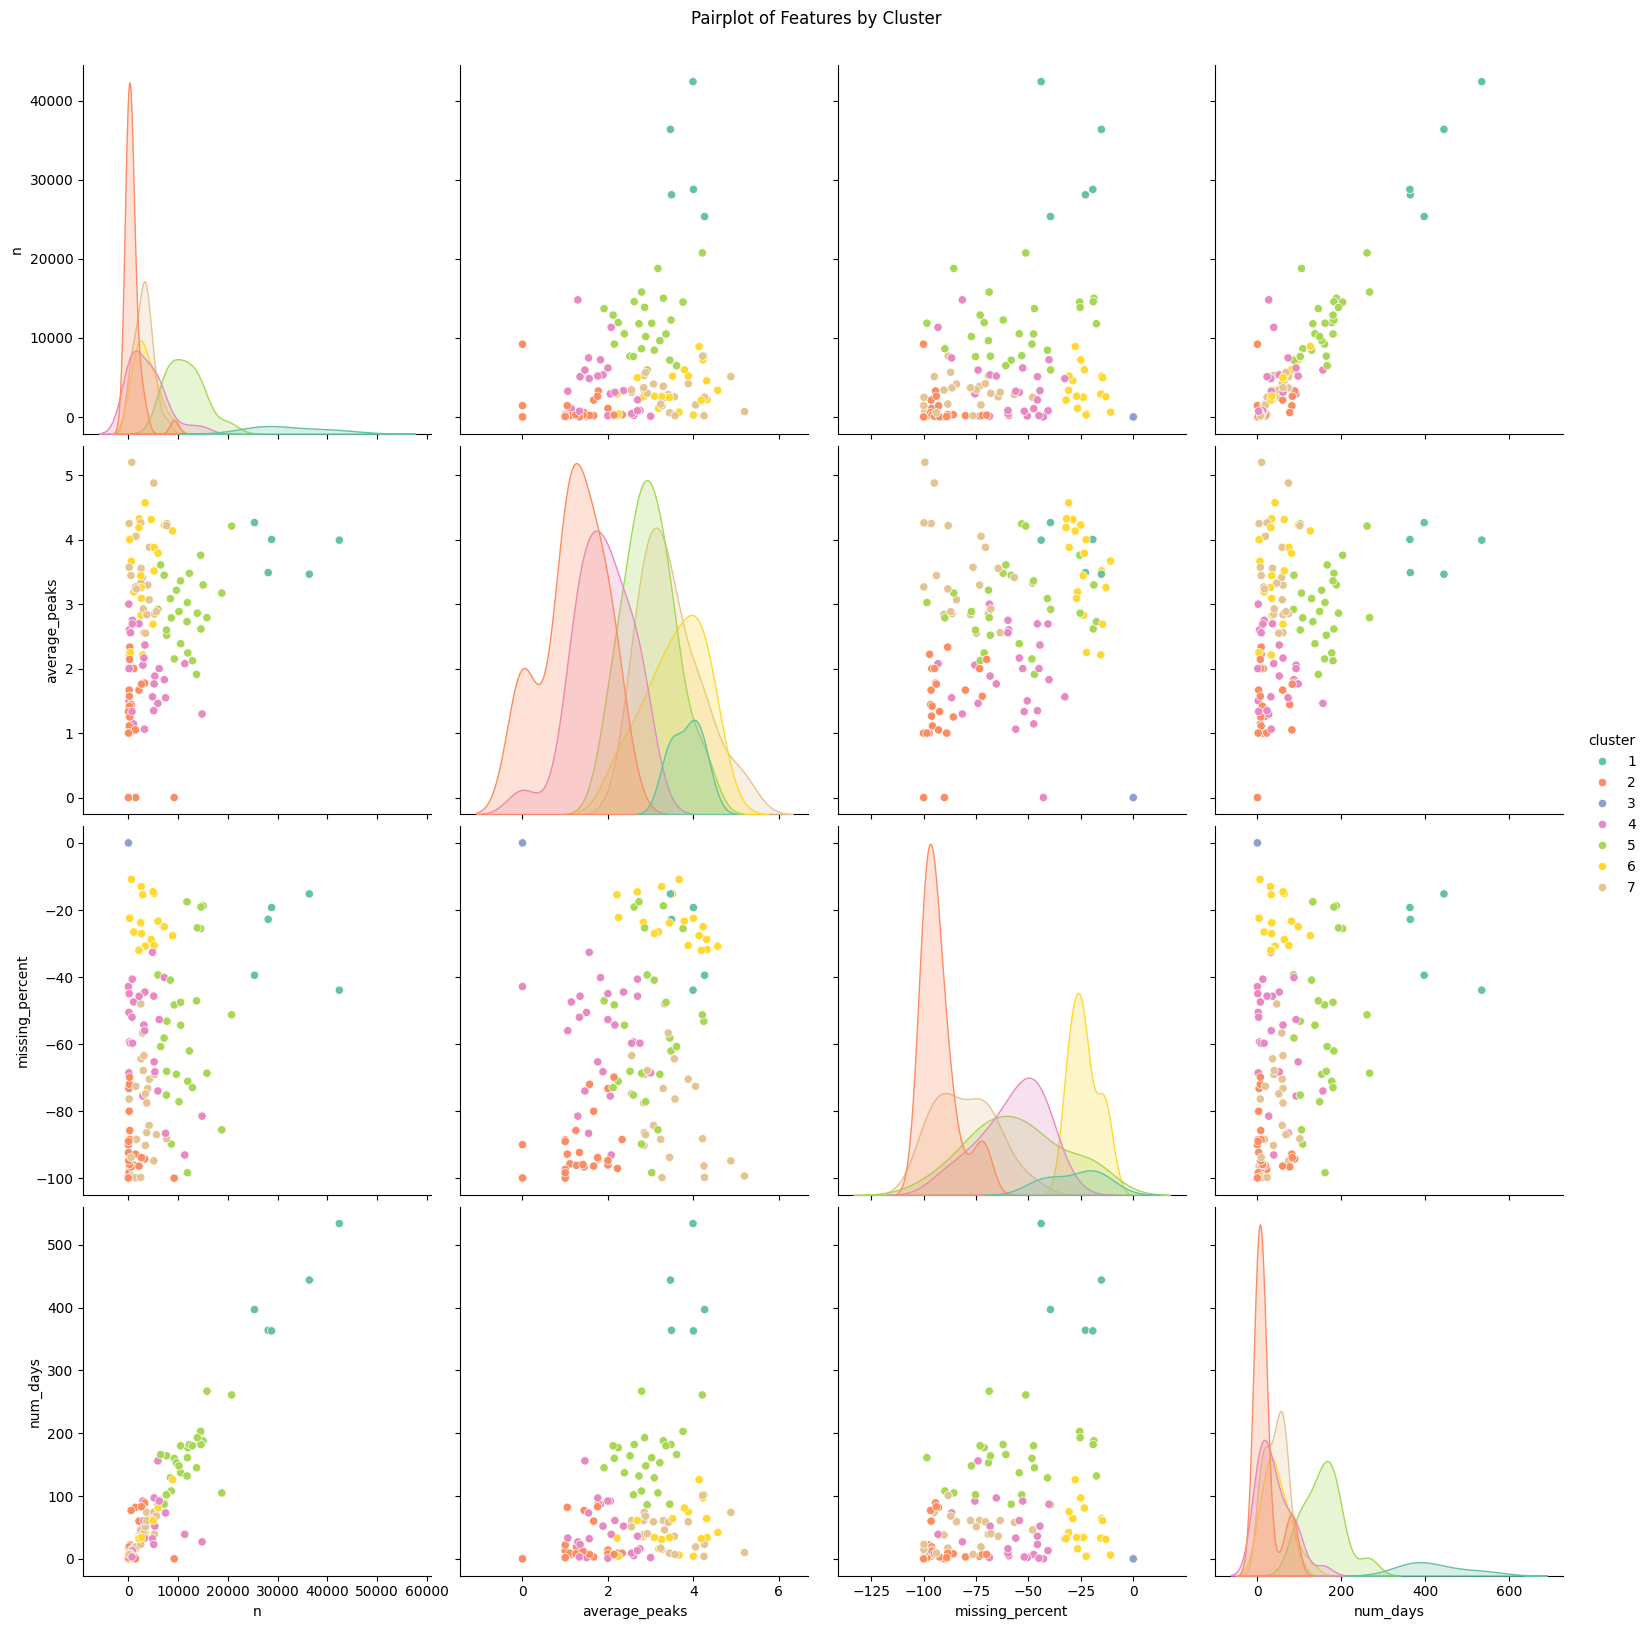

In [11]:
exclude = 17161370
df_summary_2 = hierarchical_clustering(df_summary.drop(index=[exclude]), feature_cols=feature_cols)

In [12]:
subset = list(df_summary.query('cluster == 1').index)
subset.append(exclude)

Now, we can apply the same day distribution of peaks analysis to the subset of people that we have identified as (more likely) having a good distribution of peaks.

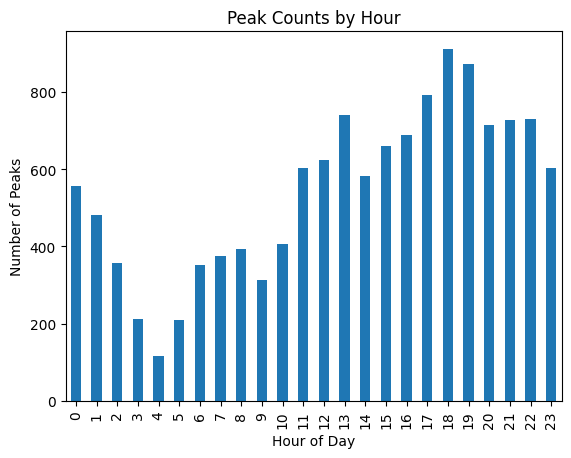

In [13]:
def plot_individual_cob(cob, pid):
    df = cob.pre_process_batch(ids=pid,
                          height=15,
                          distance=5,
                          suppress=True)
    plot_cob_by_hour(df)

plot_individual_cob(cob_new, subset)

Lets have a look at the outlier individual, given that if there is an underlying distribution with their data that skews the data in a particular way, we may be able to identify it and choose to exclude it from the analysis.

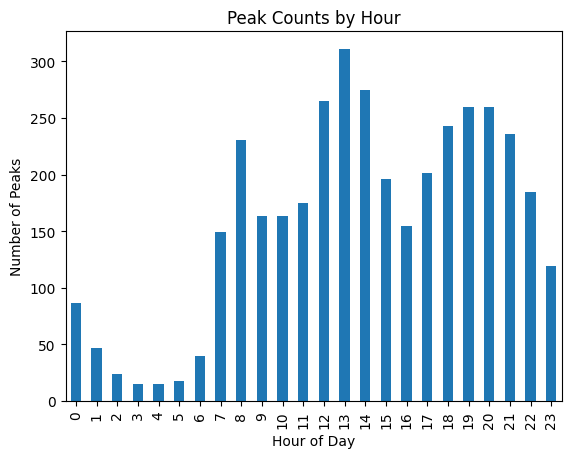

In [14]:
plot_individual_cob(cob_new, [exclude])

Now we see an anticipated distribution. There is a peak in the morning, at around a normal lunchtime in the UK, and then a peak in the evening. This is a very different distribution to the one we see in the full sample.

In [15]:
id_list = list(cob_new_df.index.get_level_values('id').unique())
print('Processed list...')
print(id_list)
print(len(id_list))
print('Pre-processed ids...')
print(len(cob_new.dataset.index.get_level_values('id').unique()))


Processed list...
[221634, 309157, 897741, 1352464, 2033176, 2050717, 2199852, 2611986, 3572116, 4762925, 5274556, 13029224, 13484299, 13783771, 14092221, 15558575, 16975609, 17161370, 18991425, 19626656, 20216809, 20396154, 20649783, 21946407, 22961398, 23428091, 24587372, 25692073, 26856617, 27700103, 27819368, 28176124, 28608066, 28768536, 32407882, 32997134, 35187603, 35533061, 35719805, 37764532, 37875431, 37948668, 37998755, 38110191, 39182506, 39986716, 40237051, 40634871, 40997757, 41131654, 41663654, 42360672, 43589707, 45025419, 47323535, 47750728, 49182092, 52804089, 54280576, 56568290, 56958831, 57176789, 60844515, 62345070, 62401782, 63047517, 64024750, 64406000, 65143138, 66019205, 66836068, 66937570, 67208817, 67359234, 68026248, 68267781, 69587086, 69965708, 70454270, 70811987, 71236754, 71397255, 71618088, 72492570, 73398408, 73521474, 74077367, 74175219, 76817975, 77104076, 77411181, 78420229, 79526193, 79751050, 80501215, 80796147, 81099003, 81680176, 84241955, 84589

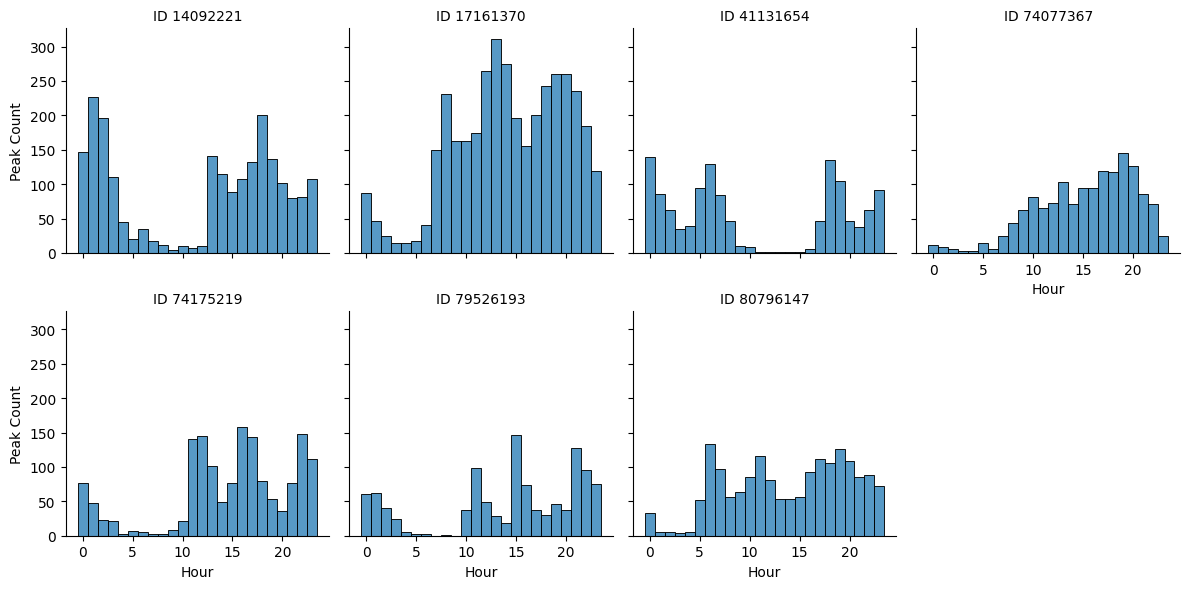

In [16]:
plot_by_hour_individuals(cob_new_df['peak'].loc[subset])

Here, there is evidence that the distributions are shifted, caused by inaccurate parsing of datetime. Particularly 14092221 and 41131654 show an odd distribution, especially the latter which infers that the person has a distribution shifted by some 10 hours (forward). Based on analysis done on the timezones, 41131654 has a timezone with a UTC offset of 12, denoted by the region in the profile file. The timestamps in the device status files do not have this timezone, therefore we can assume that these timestamps need the offset applying in order to localise them properly.Lets apply this and compare the distributions as this might be a treatment required across all individuals.

In [29]:
zip_id = 41131654

df_offset = cob_new.pre_process_batch(ids=[zip_id],
                                      height=15,
                                      distance=5,
                                      suppress=True)
df_offset.reset_index(inplace=True)
df_offset.head()

,id,datetime,cob max,day,time,cob interpolate,peak
0,41131654,2019-08-31 13:15:00+00:00,0.0,2019-08-31,13:15:00,0.0,0
1,41131654,2019-08-31 13:30:00+00:00,NaN,2019-08-31,13:30:00,0.0,0
2,41131654,2019-08-31 13:45:00+00:00,NaN,2019-08-31,13:45:00,0.0,0
3,41131654,2019-08-31 14:00:00+00:00,NaN,2019-08-31,14:00:00,0.0,0
4,41131654,2019-08-31 14:15:00+00:00,NaN,2019-08-31,14:15:00,0.0,0


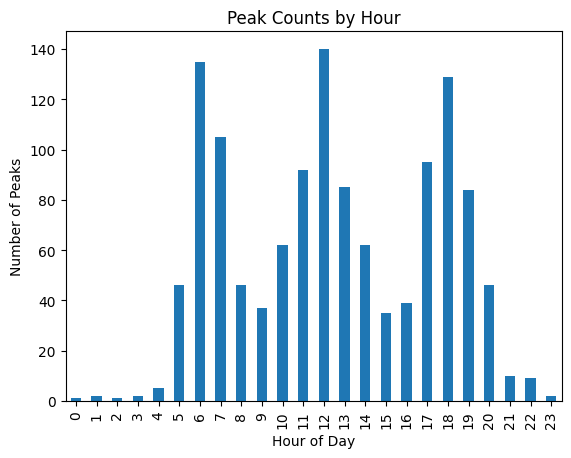

In [30]:

df_offset['datetime'] = df_offset['datetime'] + pd.Timedelta(hours=12)
df_offset['date'] = df_offset['datetime'].dt.date
df_offset['time'] = df_offset['datetime'].dt.time
df_offset.set_index(['id','datetime'], inplace=True)

plot_cob_by_hour(df_offset)

This appears to have corrected the distribution to one that is expected. So now, if we look at all the subset and adjust their offsets, do we get a different picture of distribution overall? Lets load the offsets and see.

In [54]:
df_regions = pd.read_csv(INTERIM_DATA_DIR / 'profile_region_utc_offset.csv', index_col=['zip_id','region_utc_offset'])

In [55]:
df_regions.loc[subset]

regions
zip_id   region_utc_offset                  
14092221 -6.0                    US/Mountain
         -6.0               America/Edmonton
         -6.0                Canada/Mountain
         -6.0                      ETC/GMT+6
         -7.0                      ETC/GMT+7
41131654  12.0              Pacific/Auckland
74077367  2.0                Europe/Belgrade
          0.0                            UTC
74175219 -4.0                     US/Eastern
79526193 -4.0                 Canada/Eastern
80796147  2.0               Europe/Amsterdam
          0.0                            UTC
17161370  1.0                  Europe/London
          0.0                            UTC
          0.0                      ETC/GMT+0
          2.0                  Europe/Madrid
          2.0                   Europe/Paris
          3.0                 Europe/Nicosia
          1.0                  Europe/Lisbon

The problem we see here is that only 3 of the subset of 7 have a single datetime. This means we will either have to be very selective of which we use by limiting it to individuals with only one timezone, or we build in the complexity of offsetting the datetimes dependent on the profile, which will take significant further time. Thus, for now, we will run the prior analysis on the subset of people with only one timezone.

In [57]:
one_tz_ids = (df_regions.
 reset_index().
 drop(columns='regions').
 drop_duplicates().
 groupby('zip_id').
 agg({'region_utc_offset':'count'}).
 query('region_utc_offset==1').
 reset_index()['zip_id'].
 to_list()
 )

In [61]:
(df_regions.loc[one_tz_ids].reset_index().groupby('zip_id').agg({'region_utc_offset':'max'})
 )


,region_utc_offset
zip_id,
221634,2.0
309157,10.0
1884126,-5.0
2033176,10.0
2050717,2.0
...,...
98340749,10.0
99296581,-7.0
99712241,-4.0
